This Notebook was created with the Kaggle notebooks

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


# Exploratory Analysis

See a sample of the data

In [2]:
PROJECT_DATA = '/kaggle/input/nlp-getting-started'
train_data = pd.read_csv(f'{PROJECT_DATA}/train.csv')
test_data = pd.read_csv(f'{PROJECT_DATA}/test.csv')
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Check class balance

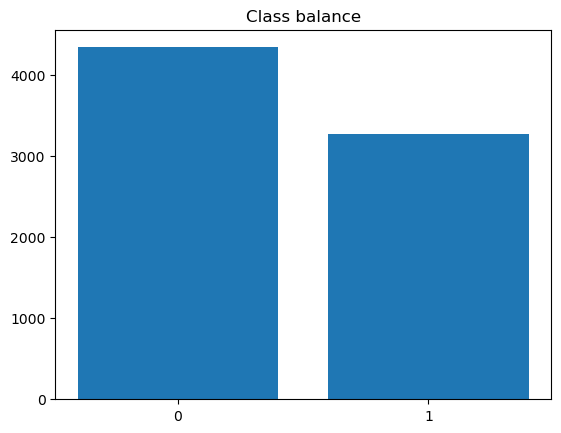

In [3]:
import matplotlib.pyplot as plt
class_count = train_data['target'].value_counts()
plt.bar(class_count.index, class_count.values, label=class_count.index)
ax = plt.gca()
ax.set_xticks(class_count.index)
ax.set_title('Class balance')
plt.show()

The classes are a little bit imbalanced, with the twits that are not disasters being the majority.

Check all the available information on the dataset.

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


# Model

Define the features and the target

In [5]:
from sklearn.model_selection import train_test_split

X_train_raw, X_valid_raw, y_train, y_valid = train_test_split(train_data['text'], train_data['target'], train_size=0.7, random_state=42)

print('Train features:',X_train_raw.size)
print('Train targets:',y_train.size)

print('Validation features:',X_valid_raw.size)
print('Validation targets:',y_valid.size)

Train features: 5329
Train targets: 5329
Validation features: 2284
Validation targets: 2284


## Pre-processing the text

In [6]:
from tensorflow.keras.layers import TextVectorization
text_vectorization = TextVectorization(output_mode='int')

text_vectorization.adapt(X_train_raw)
X_train = text_vectorization(X_train_raw)
X_valid = text_vectorization(X_valid_raw)
X_test = text_vectorization(test_data['text'])
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(5329, 31)
(2284, 30)
(3263, 31)


## Baseline model

In [7]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.5770577933450087

The accuracy of this baseline model is 57.7%.

## Transformer encoder model

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential([layers.Dense(dense_dim, activation='relu'), layers.Dense(embed_dim)])
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
    
    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(inputs, inputs, attention_mask = mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'embed_dim': self.embed_dim,
            'num_heads': self.num_heads,
            'dense_dim': self.dense_dim
        })
        return config
        

In [9]:
vocab_size = 30000
embed_dim = 512
num_heads = 8
dense_dim = 32

inputs = keras.Input(shape=(None,), dtype='int64')
x = layers.Embedding(vocab_size, embed_dim)(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs, outputs)
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 512)         15360000  
                                                                 
 transformer_encoder (Transf  (None, None, 512)        8436768   
 ormerEncoder)                                                   
                                                                 
 global_average_pooling1d (G  (None, 512)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 513   

In [10]:
callbacks = [keras.callbacks.ModelCheckpoint('transformer_encoder.keras', save_best_only=True)]

model.fit(X_train, y_train, validation_data=[X_valid, y_valid], epochs=20, callbacks=callbacks)

Epoch 1/20
167/167 [==============================] - 22s 90ms/step - loss: 0.9346 - accuracy: 0.5175 - val_loss: 0.7404 - val_accuracy: 0.4295
Epoch 2/20
167/167 [==============================] - 7s 42ms/step - loss: 0.6914 - accuracy: 0.5825 - val_loss: 0.5854 - val_accuracy: 0.7268
Epoch 3/20
167/167 [==============================] - 5s 29ms/step - loss: 0.5175 - accuracy: 0.7517 - val_loss: 0.4757 - val_accuracy: 0.8078
Epoch 4/20
167/167 [==============================] - 4s 26ms/step - loss: 0.3801 - accuracy: 0.8409 - val_loss: 0.4519 - val_accuracy: 0.8047
Epoch 5/20
167/167 [==============================] - 4s 24ms/step - loss: 0.2889 - accuracy: 0.8833 - val_loss: 0.5174 - val_accuracy: 0.7553
Epoch 6/20
167/167 [==============================] - 4s 26ms/step - loss: 0.2253 - accuracy: 0.9163 - val_loss: 0.5996 - val_accuracy: 0.8078
Epoch 7/20
167/167 [==============================] - 4s 24ms/step - loss: 0.1745 - accuracy: 0.9324 - val_loss: 0.7267 - val_accuracy: 0.789

KeyboardInterrupt: 

### Model evaluation

In [11]:
model = keras.models.load_model(
    "/kaggle/working/transformer_encoder.keras",
    custom_objects={"TransformerEncoder": TransformerEncoder})

In [12]:
model.evaluate(X_valid, y_valid)

72/72 [==============================] - 1s 8ms/step - loss: 0.4519 - accuracy: 0.8047


[0.4519490897655487, 0.8047285676002502]

## Pretrained model

In [6]:
from transformers import AutoTokenizer, DataCollatorWithPadding
import numpy as np

checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [7]:
from collections import defaultdict
from datasets import DatasetDict, Dataset

d_train = Dataset.from_dict(tokenizer(list(X_train_raw)))
d_train = d_train.add_column(name='target', column=list(y_train))

d_valid = Dataset.from_dict(tokenizer(list(X_valid_raw)))
d_valid = d_valid.add_column(name='target', column=list(y_valid))

dataset = {'train': d_train, 'test':  d_valid}

In [8]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

tf_train_dataset = dataset['train'].to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["target"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=64,
)

tf_validation_dataset = dataset['test'].to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["target"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=64,
)

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [9]:
from transformers import TFAutoModelForSequenceClassification

model_pt = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'dropout_19', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [10]:
model_pt.layers[0].trainable = False
model_pt.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66,955,010
Trainable params: 592,130
Non-trainable params: 66,362,880
_________________________________________________________________


In [11]:
from tensorflow.keras.optimizers.schedules import PolynomialDecay

num_epochs = 15
# The number of training steps is the number of samples in the dataset, divided by the batch size then multiplied
# by the total number of epochs. Note that the tf_train_dataset here is a batched tf.data.Dataset,
# not the original Hugging Face Dataset, so its len() is already num_samples // batch_size.
num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=lr_scheduler)

In [12]:
from tensorflow import keras
import tensorflow as tf
model_pt.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

model_pt.fit(tf_train_dataset,
    validation_data=tf_validation_dataset, epochs=num_epochs)

Epoch 1/15
83/83 [==============================] - 24s 171ms/step - loss: 0.6185 - accuracy: 0.6873 - val_loss: 0.5346 - val_accuracy: 0.7986
Epoch 2/15
83/83 [==============================] - 10s 124ms/step - loss: 0.5182 - accuracy: 0.7730 - val_loss: 0.4693 - val_accuracy: 0.8052
Epoch 3/15
83/83 [==============================] - 10s 124ms/step - loss: 0.4787 - accuracy: 0.7784 - val_loss: 0.4460 - val_accuracy: 0.8135
Epoch 4/15
83/83 [==============================] - 12s 151ms/step - loss: 0.4616 - accuracy: 0.7925 - val_loss: 0.4353 - val_accuracy: 0.8179
Epoch 5/15
83/83 [==============================] - 10s 124ms/step - loss: 0.4515 - accuracy: 0.7942 - val_loss: 0.4310 - val_accuracy: 0.8196
Epoch 6/15
83/83 [==============================] - 12s 149ms/step - loss: 0.4426 - accuracy: 0.7984 - val_loss: 0.4270 - val_accuracy: 0.8196
Epoch 7/15
83/83 [==============================] - 12s 150ms/step - loss: 0.4325 - accuracy: 0.8025 - val_loss: 0.4242 - val_accuracy: 0.8231

In [13]:
model_pt.layers[0].trainable = True
num_epochs = 5
num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-6, end_learning_rate=5e-8, decay_steps=num_train_steps
)
opt = Adam(learning_rate=lr_scheduler)

model_pt.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

model_pt.fit(tf_train_dataset,
    validation_data=tf_validation_dataset, epochs=num_epochs)

Epoch 1/5
83/83 [==============================] - 51s 368ms/step - loss: 0.4186 - accuracy: 0.8121 - val_loss: 0.3973 - val_accuracy: 0.8341
Epoch 2/5
83/83 [==============================] - 24s 288ms/step - loss: 0.3804 - accuracy: 0.8343 - val_loss: 0.3890 - val_accuracy: 0.8380
Epoch 3/5
83/83 [==============================] - 25s 302ms/step - loss: 0.3574 - accuracy: 0.8460 - val_loss: 0.3872 - val_accuracy: 0.8411
Epoch 4/5
83/83 [==============================] - 25s 296ms/step - loss: 0.3452 - accuracy: 0.8539 - val_loss: 0.3936 - val_accuracy: 0.8349
Epoch 5/5
83/83 [==============================] - 25s 296ms/step - loss: 0.3353 - accuracy: 0.8599 - val_loss: 0.3896 - val_accuracy: 0.8367


In [23]:
X_test = tokenizer(list(test_data['text']))
d_test = Dataset.from_dict(X_test)
tf_test_dataset = d_test.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=64,
)

In [24]:
preds = model_pt.predict(tf_test_dataset)

51/51 [==============================] - 6s 81ms/step


In [27]:
pred_labels = np.argmax(preds.logits, axis=1)

In [40]:
submission_df = pd.DataFrame({'id': test_data['id'],'target':pred_labels})

In [43]:
submission_df.to_csv('/kaggle/working/submission.csv')